<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/FineTunedChemberta(DeepChem_ChemBERTa_10M_MLM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fined Tuned pretained Chemberta(DeepChem_ChemBERTa_10M_MLM) -- classification modeling

## Introduction

 While not outperforming existing methods, ChemBERTa demonstrates competitive results when trained on larger datasets. It enhances interpretability and introduces an innovative attention-based visualization for elucidating the model's decision-making process. By directly accepting SMILES strings as input, ChemBERTa eliminates the need for extensive featurization, thus facilitating rapid screening(Ahmad et al., 2022; Chithrananda et al., 2020). We utilized twelve different variants of CheMERTa, pre-trained in different size and type of dataset, along with rigorous hyper parameter optimization via Optuna module (Chithrananda et al., 2020). Preferred tokenizer was the default RoBERTA tokenizer as there was no significant difference in performance across different tokenizers.


## Data loading and Preprocessing



In [ ]:
import numpy as np
# Reproducibility
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 20.1 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx')
df.head()

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
df['classLabel'].value_counts()

classLabel
0    2330
1    1747
Name: count, dtype: int64

In [ ]:
df_selected= df[['Smiles', 'classLabel']]
df_selected

,Smiles,classLabel
0,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,1
1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,1
2,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,0
3,Cc1ccc2c(N)c3c(nc2c1)CCCC3,1
4,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,1
...,...,...
4072,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,1
4073,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],0
4074,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],0
4075,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],1


 The following code for roberta tokenizer and chemberta model building is adopted from deepchem's tutorial: (https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb)

In [ ]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np
import deepchem as dc

In [ ]:
df.to_csv('inhibitor.csv', index=False)

In [ ]:
dataset_file = 'inhibitor.csv'
task = ['classLabel']
featurizer_func = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=task, feature_field='cleanedMol', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

In [ ]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

In [ ]:
from rdkit import Chem

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

Cloning into 'apex'...
remote: Enumerating objects: 11703, done.
remote: Counting objects: 100% (3796/3796), done.
remote: Compressing objects: 100% (620/620), done.
remote: Total 11703 (delta 3409), reused 3323 (delta 3172), pack-reused 7907
Receiving objects: 100% (11703/11703), 15.50 MiB | 8.11 MiB/s, done.
Resolving deltas: 100% (8211/8211), done.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Processing ./apex
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.4/863.4 kB 8.7 MB/s eta 0:00:00
    Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
    Creating /tmp/pip-build-env-c4zqf_74/overlay/local/bin
    changing mode of /tmp/pip-build-env-c4zqf_74/overlay/local/bin/wheel to 755
  ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
Receiving objects: 100% (1633/1633), 198.37 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


In [ ]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1566, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1566 (delta 96), reused 92 (delta 91), pack-reused 1364
Receiving objects: 100% (1566/1566), 55.35 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.
Updating files: 100% (122/122), done.


In [ ]:
%cd /content/bert-loves-chemistry

/content/bert-loves-chemistry


In [ ]:
import os
import numpy as np
import pandas as pd
from typing import List
from rdkit import Chem

In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install transformers

In [ ]:
import deepchem as dc
import pandas as pd

task = ['classLabel']
dataset = dc.data.NumpyDataset(X=df['cleanedMol'], y=df['classLabel'])
splitter = dc.splits.RandomSplitter()
frac_train = 0.7
frac_valid = 0.15
frac_test = 0.15

# Split the dataset
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset, frac_train=frac_train, frac_valid=frac_valid, frac_test=frac_test
)

In [ ]:
test_dataset

<NumpyDataset X.shape: (612,), y.shape: (612,), w.shape: (612,), ids: [3356 2744 3859 ... 860 3507 3174], task_names: [0]>

In [ ]:
train_df = train_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()

In [ ]:
train_df

,X,y,w,ids
0,Clc1ccc(CN2CCN(c3nccc(NCc4ccccc4)n3)CC2)cc1,0,1.0,1749
1,CCCCNC(=O)Oc1cccc(CN(C)CCCOc2ccc3ccc(=O)oc3c2)c1,1,1.0,2053
2,Cc1cccc(C[n+]2ccc(C(=O)NCCc3c[nH]c4ccccc34)cc2)c1,0,1.0,538
3,CN(C)CCCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2,1,1.0,438
4,COc1cc2c(cc1OC)SC(C(=O)CCc1cc[n+](Cc3ccsc3)cc1)C2,1,1.0,2685
...,...,...,...,...
2848,CC1=Nc2nc3c(c(N)c2C(c2ccccc2F)C1C(=O)OC1CCC1)C...,1,1.0,2927
2849,COc1cc2c(cc1OC)C(c1ccccc1)N(CCCCCCc1cc(C)nc(C=...,0,1.0,375
2850,CC1CN(C(=O)Oc2ccc(Oc3ccc(C(F)(F)F)cn3)cc2)CC(C)O1,0,1.0,1908
2851,CN(C)Cc1ccc(CSCCCCCCCCCCSCc2ccc(CN(C)C)o2)o1,0,1.0,333


In [ ]:
train_df=train_df[['X','y']]
valid_df=valid_df[['X','y']]
test_df=test_df[['X','y']]

## Model Building

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-10M-MLM', use_cuda=True, args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}) # You can set class weights by using the optional weight argument


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [ ]:
# Create directory to store model weights
!mkdir AChE_transferLearning
# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/AChE_transferLearning')

mkdir: cannot create directory ‘AChE_transferLearning2’: File exists


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

(3570, 0.37593020235164826)

## Cross species evaluation

### Upload and prep for species dataset

Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.





In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndependent.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mosquito.xlsx')

In [ ]:
df_humanIndependent = dc.data.NumpyDataset(X=df_humanIndependent['cleanedMol'], y=df_humanIndependent['binary_activities'])
df_eel = dc.data.NumpyDataset(X=df_eel['cleanedMol'], y=df_eel['single-class-label'])
df_mouse = dc.data.NumpyDataset(X=df_mouse['cleanedMol'], y=df_mouse['single-class-label'])
df_cow = dc.data.NumpyDataset(X=df_cow['cleanedMol'], y=df_cow['single-class-label'])
df_ray = dc.data.NumpyDataset(X=df_ray['cleanedMol'], y=df_ray['single-class-label'])
df_mosquito = dc.data.NumpyDataset(X=df_mosquito['cleanedMol'], y=df_mosquito['single-class-label'])

In [ ]:
df_humanIndependent = df_humanIndependent.to_dataframe()
df_eel = df_eel.to_dataframe()
df_mouse = df_mouse.to_dataframe()
df_cow = df_cow.to_dataframe()
df_ray = df_ray.to_dataframe()
df_mosquito = df_mosquito.to_dataframe()

In [ ]:
df_humanIndependent=df_humanIndependent[['X','y']]
df_eel=df_eel[['X','y']]
df_mouse=df_mouse[['X','y']]
df_cow=df_cow[['X','y']]
df_ray=df_ray[['X','y']]
df_mosquito=df_mosquito[['X','y']]

In [ ]:
df_humanIndependent

,X,y
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0
...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1


### Cross species evaluation

In [ ]:
import pandas as pd
import numpy as np
import sklearn

all_results = []
all_model_outputs = []
all_wrong_predictions = []

datasets = [df_humanIndependent, df_eel, df_mouse, df_cow, df_ray, df_mosquito]

species_names = ['humanIndependent', 'eel', 'mouse', 'cow', 'ray', 'mosquito']

for dataset, species_name in zip(datasets, species_names):
    # Convert NumpyDataset to Pandas DataFrame
    data_dict = {'cleanedMol': np.asarray(dataset.X), 'single-class-label': np.asarray(dataset.y)}
    current_df = pd.DataFrame(data_dict)

    # Perform evaluation
    result_test, model_outputs_test, wrong_predictions_test = model.eval_model(current_df, acc=sklearn.metrics.accuracy_score)

    # Append results for the current species to the lists
    all_results.append(pd.DataFrame({'Species': [species_name], 'Accuracy': [result_test]}))
    all_model_outputs.append(pd.DataFrame({'Species': [species_name], 'Model Outputs': [model_outputs_test]}))
    all_wrong_predictions.append(pd.DataFrame({'Species': [species_name], 'Wrong Predictions': [wrong_predictions_test]}))

# Concatenate all results DataFrames
results_df = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df.to_excel('all_results.xlsx', index=False)
model_outputs_df.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import sklearn.metrics

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

evaluation_results = {}

for dataset_name, dataset in datasets.items():
    result, model_outputs, wrong_predictions = model.eval_model(dataset, acc=sklearn.metrics.accuracy_score)
    evaluation_results[dataset_name] = {
        'result': result,
        'model_outputs': model_outputs,
        'wrong_predictions': wrong_predictions
    }

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for dataset_name, result in evaluation_results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Evaluation result: {result['result']}")

Dataset: Human Test
Evaluation result: {'mcc': 0.6645366927296159, 'accuracy': 0.8366013071895425, 'f1_score': 0.8046874999999999, 'tp': 206, 'tn': 306, 'fp': 54, 'fn': 46, 'auroc': 0.9035714285714286, 'auprc': 0.8704528412548698, 'acc': 0.8366013071895425, 'eval_loss': 0.6135878009455544}

Dataset: Human Independent
Evaluation result: {'mcc': 0.39896346029442786, 'accuracy': 0.7211538461538461, 'f1_score': 0.6133333333333333, 'tp': 46, 'tn': 104, 'fp': 34, 'fn': 24, 'auroc': 0.7992236024844721, 'auprc': 0.7661102702164014, 'acc': 0.7211538461538461, 'eval_loss': 0.6390628218650818}

Dataset: Eel
Evaluation result: {'mcc': 0.33572555705414264, 'accuracy': 0.6871221835501008, 'f1_score': 0.5878378378378378, 'tp': 1218, 'tn': 2533, 'fp': 842, 'fn': 866, 'auroc': 0.732173171251866, 'auprc': 0.6758425799965777, 'acc': 0.6871221835501008, 'eval_loss': 0.961242943460291}

Dataset: Mouse
Evaluation result: {'mcc': 0.44413968269278614, 'accuracy': 0.6983695652173914, 'f1_score': 0.689075630252

In [ ]:
import pandas as pd

# Convert evaluation_results dictionary to a DataFrame
df_evaluation_results = pd.DataFrame(evaluation_results)

# Transpose the DataFrame so that datasets are in rows and metrics are in columns
df_evaluation_results = df_evaluation_results.T

# Save the DataFrame to an Excel file
print(f"Evaluation results have been saved to {excel_file_path}")


Evaluation results have been saved to evaluation_results_DeepChem/ChemBERTa-10M-MLM.xlsx


Confusion Matrix for Human Test dataset:
[[306  54]
 [ 46 206]]
Confusion Matrix for Human Independent dataset:
[[104  34]
 [ 24  46]]
Confusion Matrix for Eel dataset:
[[2533  842]
 [ 866 1218]]
Confusion Matrix for Mouse dataset:
[[134  89]
 [ 22 123]]
Confusion Matrix for Cow dataset:
[[131  87]
 [ 32 207]]
Confusion Matrix for Ray dataset:
[[435 284]
 [258 429]]
Confusion Matrix for Mosquito dataset:
[[34 11]
 [12 15]]


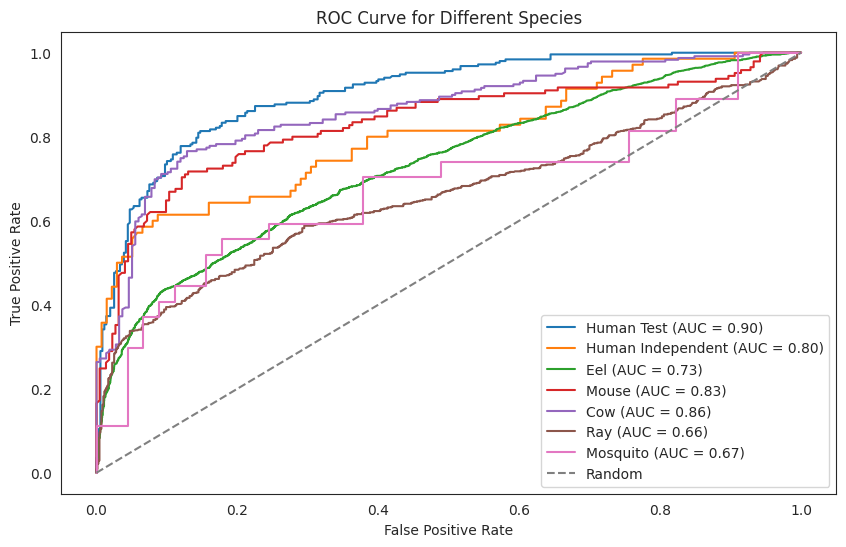

Evaluation for Human Test dataset:
Accuracy: 0.8366
Precision: 0.7923
Recall: 0.8175
F1 Score: 0.8047
MCC: 0.6645
Cohen's Kappa: 0.6643


Evaluation for Human Independent dataset:
Accuracy: 0.7212
Precision: 0.5750
Recall: 0.6571
F1 Score: 0.6133
MCC: 0.3990
Cohen's Kappa: 0.3968


Evaluation for Eel dataset:
Accuracy: 0.6871
Precision: 0.5913
Recall: 0.5845
F1 Score: 0.5878
MCC: 0.3357
Cohen's Kappa: 0.3357


Evaluation for Mouse dataset:
Accuracy: 0.6984
Precision: 0.5802
Recall: 0.8483
F1 Score: 0.6891
MCC: 0.4441
Cohen's Kappa: 0.4156


Evaluation for Cow dataset:
Accuracy: 0.7396
Precision: 0.7041
Recall: 0.8661
F1 Score: 0.7767
MCC: 0.4870
Cohen's Kappa: 0.4723


Evaluation for Ray dataset:
Accuracy: 0.6145
Precision: 0.6017
Recall: 0.6245
F1 Score: 0.6129
MCC: 0.2294
Cohen's Kappa: 0.2293


Evaluation for Mosquito dataset:
Accuracy: 0.6806
Precision: 0.5769
Recall: 0.5556
F1 Score: 0.5660
MCC: 0.3136
Cohen's Kappa: 0.3134




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Evaluate and plot ROC curve for each dataset
for species, result in evaluation_results.items():
    y_true = datasets[species].y.ravel()
    y_pred_positive = result['model_outputs'][:, 1]

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_positive)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Calculate the confusion matrix
    y_pred_binary = np.argmax(result['model_outputs'], axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred_binary)

    # Calculate other evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    cohen_kappa = cohen_kappa_score(y_true, y_pred_binary)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa
    }

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(conf_matrix)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('FineTunedChemberta(DeepChem_ChemBERTa_77M_MLM).xlsx', index_label='Species')


## Model optimization

In [ ]:
!pip install Optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
import optuna
from sklearn.metrics import roc_auc_score
from simpletransformers.classification.classification_model import ClassificationModel
classification_args = {
    'overwrite_output_dir': True,  # Set to True to overwrite the output directory if it exists
}

# Define the objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 10)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 1000)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-9, 1e-7, log=True)
    # Generate a unique output directory for each trial
    output_dir = f'/content/AChE_transferLearning_trial_{trial.number}'

    # Create and train the model with the given hyperparameters
    model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-10M-MLM', use_cuda=True, args={**classification_args, 'learning_rate': learning_rate, 'num_train_epochs': num_train_epochs, 'train_batch_size': batch_size, 'dropout': dropout, 'warmup_steps': warmup_steps, 'weight_decay': weight_decay, 'adam_epsilon': adam_epsilon})

    model.train_model(train_df, eval_df=valid_df)

    # Evaluate the model and calculate ROC AUC
    eval_results = model.eval_model(valid_df)
    predictions, _ = model.predict(valid_df['X'].tolist())
    roc_auc = roc_auc_score(valid_df['y'].tolist(), predictions)

    # Return ROC AUC for optimization
    return roc_auc

# Create an Optuna study and optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-10M-MLM', use_cuda=True, args={**classification_args, **best_params})
final_model.train_model(train_df, eval_df=valid_df)


[I 2024-05-22 00:07:26,430] A new study created in memory with name: no-name-4f954a16-721f-4346-ac27-9c202b0301fc
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 7 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:08:04,638] Trial 0 finished with value: 0.5859333369582949 and parameters: {'learning_rate': 4.055983458740719e-06, 'num_train_epochs': 7, 'batch_size': 16, 'dropout': 0.3664924745505612, 'warmup_steps': 593, 'weight_decay': 0.18387873974570199, 'adam_epsilon': 8.440592204507157e-09}. Best is trial 0 with value: 0.5859333369582949.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:08:34,951] Trial 1 finished with value: 0.7617095318362241 and parameters: {'learning_rate': 1.6110000118139934e-05, 'num_train_epochs': 6, 'batch_size': 16, 'dropout': 0.24674602875345253, 'warmup_steps': 754, 'weight_decay': 0.021384130864820116, 'adam_epsilon': 3.5584399745335884e-09}. Best is trial 1 with value: 0.7617095318362241.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:09:13,134] Trial 2 finished with value: 0.5293295633733892 and parameters: {'learning_rate': 1.1873770340622078e-06, 'num_train_epochs': 4, 'batch_size': 8, 'dropout': 0.10175657712304204, 'warmup_steps': 886, 'weight_decay': 0.13237480284063297, 'adam_epsilon': 2.785540896921524e-08}. Best is trial 1 with value: 0.7617095318362241.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 7 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:09:49,731] Trial 3 finished with value: 0.786031210918384 and parameters: {'learning_rate': 1.5975312381978515e-05, 'num_train_epochs': 7, 'batch_size': 16, 'dropout': 0.41202166049095834, 'warmup_steps': 652, 'weight_decay': 0.13796038791755483, 'adam_epsilon': 1.2328267044352895e-09}. Best is trial 3 with value: 0.786031210918384.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:10:01,627] Trial 4 finished with value: 0.8459300744929585 and parameters: {'learning_rate': 0.00037071759041729563, 'num_train_epochs': 3, 'batch_size': 32, 'dropout': 0.1513019005462932, 'warmup_steps': 77, 'weight_decay': 0.1571155405918396, 'adam_epsilon': 3.6655654864386324e-09}. Best is trial 4 with value: 0.8459300744929585.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:10:18,972] Trial 5 finished with value: 0.8043499537817412 and parameters: {'learning_rate': 0.0008257680196827171, 'num_train_epochs': 5, 'batch_size': 32, 'dropout': 0.4839712496009865, 'warmup_steps': 602, 'weight_decay': 0.1929891782488499, 'adam_epsilon': 5.660344331775553e-09}. Best is trial 4 with value: 0.8459300744929585.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:10:26,440] Trial 6 finished with value: 0.6590016856070905 and parameters: {'learning_rate': 3.850877945440817e-05, 'num_train_epochs': 1, 'batch_size': 16, 'dropout': 0.18041827506511657, 'warmup_steps': 161, 'weight_decay': 0.16730161428968301, 'adam_epsilon': 3.5364179422762414e-09}. Best is trial 4 with value: 0.8459300744929585.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:10:47,177] Trial 7 finished with value: 0.5925887662443586 and parameters: {'learning_rate': 9.653777852452612e-06, 'num_train_epochs': 6, 'batch_size': 32, 'dropout': 0.3943326395069989, 'warmup_steps': 930, 'weight_decay': 0.08832960593041474, 'adam_epsilon': 1.0071692610920355e-09}. Best is trial 4 with value: 0.8459300744929585.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:10:59,504] Trial 8 finished with value: 0.8065466804415203 and parameters: {'learning_rate': 0.000638784099948651, 'num_train_epochs': 2, 'batch_size': 16, 'dropout': 0.3220177188034353, 'warmup_steps': 533, 'weight_decay': 0.27975459851659823, 'adam_epsilon': 1.0532024032168206e-08}. Best is trial 4 with value: 0.8459300744929585.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-05-22 00:11:47,384] Trial 9 finished with value: 0.8002338100157687 and parameters: {'learning_rate': 2.4172033687793384e-05, 'num_train_epochs': 5, 'batch_size': 8, 'dropout': 0.2516203673908334, 'warmup_steps': 781, 'weight_decay': 0.06271002775969227, 'adam_epsilon': 3.808954673273746e-08}. Best is trial 4 with value: 0.8459300744929585.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Best Hyperparameters: {'learning_rate': 0.00037071759041729563, 'num_train_epochs': 3, 'batch_size': 32, 'dropout': 0.1513019005462932, 'warmup_steps': 77, 'weight_decay': 0.1571155405918396, 'adam_epsilon': 3.6655654864386324e-09}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/357 [00:00<?, ?it/s]

(1071, 0.43105549903031715)

In [ ]:
best_params

{'learning_rate': 0.00037071759041729563,
 'num_train_epochs': 3,
 'batch_size': 32,
 'dropout': 0.1513019005462932,
 'warmup_steps': 77,
 'weight_decay': 0.1571155405918396,
 'adam_epsilon': 3.6655654864386324e-09}

### Optimized model cross species evaluation

In [ ]:
import pandas as pd
import numpy as np
import sklearn

# Initialize empty lists to store results for each species
all_results = []
all_model_outputs = []
all_wrong_predictions = []

# Assuming you have a list of datasets
datasets = [df_humanIndependent, df_eel, df_mouse, df_cow, df_ray, df_mosquito]

# Manually define species names
species_names = ['humanIndependent', 'eel', 'mouse', 'cow', 'ray', 'mosquito']

for dataset, species_name in zip(datasets, species_names):
    # Convert NumpyDataset to Pandas DataFrame
    data_dict = {'cleanedMol': np.asarray(dataset.X), 'single-class-label': np.asarray(dataset.y)}
    current_df = pd.DataFrame(data_dict)

    # Perform evaluation
    result_test_final, model_outputs_final, wrong_predictions_final = final_model.eval_model(current_df, acc=sklearn.metrics.accuracy_score)

    # Append results for the current species to the lists
    all_results.append(pd.DataFrame({'Species': [species_name], 'Accuracy': [result_test_final]}))
    all_model_outputs.append(pd.DataFrame({'Species': [species_name], 'Model Outputs': [model_outputs_final]}))
    all_wrong_predictions.append(pd.DataFrame({'Species': [species_name], 'Wrong Predictions': [wrong_predictions_final]}))

# Concatenate all results DataFrames
results_df_final = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df_final = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df_final = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df_final.to_excel('all_results.xlsx', index=False)
model_outputs_df_final.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df_final.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import sklearn.metrics

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

evaluation_results = {}

for dataset_name, dataset in datasets.items():
    result_final, model_outputs_final, wrong_predictions_final = final_model.eval_model(dataset, acc=sklearn.metrics.accuracy_score)
    evaluation_results[dataset_name] = {
        'result': result_final,
        'model_outputs': model_outputs_final,
        'wrong_predictions': wrong_predictions_final
    }

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for dataset_name, result in evaluation_results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Evaluation result: {result['result']}")
    print()

Dataset: Human Test
Evaluation result: {'mcc': 0.6415529444852698, 'accuracy': 0.8218954248366013, 'f1_score': 0.7954971857410883, 'tp': 212, 'tn': 291, 'fp': 69, 'fn': 40, 'auroc': 0.9034667107583774, 'auprc': 0.8660710593834747, 'acc': 0.8218954248366013, 'eval_loss': 0.5737246019499642}

Dataset: Human Independent
Evaluation result: {'mcc': 0.39374580666181075, 'accuracy': 0.7115384615384616, 'f1_score': 0.6153846153846154, 'tp': 48, 'tn': 100, 'fp': 38, 'fn': 22, 'auroc': 0.8059006211180125, 'auprc': 0.778101575156951, 'acc': 0.7115384615384616, 'eval_loss': 0.5802397926648458}

Dataset: Eel
Evaluation result: {'mcc': 0.3421963253030216, 'accuracy': 0.6840080600842645, 'f1_score': 0.6031746031746031, 'tp': 1311, 'tn': 2423, 'fp': 952, 'fn': 773, 'auroc': 0.7228314494917183, 'auprc': 0.6876576037022917, 'acc': 0.6840080600842645, 'eval_loss': 0.9044210076332092}

Dataset: Mouse
Evaluation result: {'mcc': 0.4059346709340381, 'accuracy': 0.657608695652174, 'f1_score': 0.671875, 'tp': 

In [ ]:
from simpletransformers.classification.classification_model import ClassificationModel
import pandas as pd

# Define transformer architectures
architectures = ["roberta", "camembert", "xlmroberta", "longformer", "mpnet", "nystromformer"]
best_model = None
best_metric = float('-inf')  # Initialize with negative infinity for maximization

# Loop through each architecture
for arch in architectures:
    print(f"Training and evaluating {arch} model...")

    # Define and train the model
    model = ClassificationModel(arch, 'DeepChem/ChemBERTa-10M-MLM', use_cuda=True,
                                args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True,
                                      'no_save': True, 'num_train_epochs': 10, 'auto_weights': True})

    model.train_model(train_df, eval_df=valid_df)

    # Evaluate the model
    result, _, _ = model.eval_model(valid_df, roc_auc=True)  # Specify to compute AUROC

    # Check if current model is the best
    if result["AUROC"] > best_metric:
        best_metric = result["AUROC"]
        best_model = model
        print(f"New best model found with AUROC: {best_metric}")

# Output the best model's performance
print(f"Best model is {best_model.model_type} with AUROC: {best_metric}")

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-63-073c15148797>, line 20)

## Model performance on different tokenizer

In [ ]:
import pandas as pd
import numpy as np
from simpletransformers.classification.classification_model import ClassificationModel
import sklearn

# Define function to train and evaluate model with a specified architecture
def train_and_evaluate(architecture, train_df, valid_df):
    # Define model with specified architecture
    model = ClassificationModel(architecture, 'DeepChem/ChemBERTa-10M-MLM', use_cuda=True,
                                args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True,
                                      'no_save': True, 'num_train_epochs': 10, 'auto_weights': True,
                                      'overwrite_output_dir': True})  # Set overwrite_output_dir=True

    # Train the model
    model.train_model(train_df, eval_df=valid_df)

    # Evaluate the model on validation data
    result_valid, model_outputs_valid, wrong_predictions_valid = model.eval_model(valid_df, acc=sklearn.metrics.accuracy_score)

    return result_valid, model_outputs_valid, wrong_predictions_valid

# Initialize empty lists to store results for each architecture
all_results = []
all_model_outputs = []
all_wrong_predictions = []

# Manually define architecture names
architectures = ["roberta", "camembert", "xlmroberta", "longformer"]

# Iterate over each architecture, train the model, and evaluate it
for architecture in architectures:
    # Train and evaluate model with current architecture
    result_valid, model_outputs_valid, wrong_predictions_valid = train_and_evaluate(architecture, train_df, valid_df)

    # Append results for the current architecture to the lists
    all_results.append(pd.DataFrame({'Architecture': [architecture], 'Accuracy': [result_valid]}))
    all_model_outputs.append(pd.DataFrame({'Architecture': [architecture], 'Model Outputs': [model_outputs_valid]}))
    all_wrong_predictions.append(pd.DataFrame({'Architecture': [architecture], 'Wrong Predictions': [wrong_predictions_valid]}))

# Concatenate all results DataFrames
results_df = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df.to_excel('all_results.xlsx', index=False)
model_outputs_df.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompa

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type roberta to instantiate a model of type camembert. This is not supported for all configurations of models and can yield errors.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you l

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class yo

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type roberta to instantiate a model of type longformer. This is not supported for all configurations of models and can yield errors.
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encod

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
results_df

,Architecture,Accuracy
0,roberta,"{'mcc': 0.6721720893271851, 'accuracy': 0.8382..."
1,camembert,"{'mcc': 0.6801133385515218, 'accuracy': 0.8398..."
2,xlmroberta,"{'mcc': 0.6542404818551748, 'accuracy': 0.8300..."
3,longformer,"{'mcc': 0.4541604281101422, 'accuracy': 0.7287..."


## References


*  https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb
*   https://huggingface.co/DeepChem

*  Ramsundar, B., Eastman, P., Walters, P., Pande, V., Leswing, K., & Wu, Z. (2019). Deep Learning for the Life Sciences. O’Reilly Media. https://www.amazon.com/Deep-Learning-Life-Sciences-Microscopy/dp/1492039837

*  Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283


*   Ahmad, W., Simon, E., Chithrananda, S., Grand, G., & Ramsundar, B. (2022). ChemBERTa-2: Towards Chemical Foundation Models (arXiv:2209.01712). arXiv. http://arxiv.org/abs/2209.01712
*   Chithrananda, S., Grand, G., & Ramsundar, B. (2020). ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction (Version 2). arXiv. https://doi.org/10.48550/ARXIV.2010.09885







